In [67]:
import requests
from json import dumps

endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
area_type = "nation"
area_name = "england"

filters = [f"areaType={area_type}", f"areaName={area_name}"] 

structure = {
    "date": "date",
    "name": "areaName",
    "code": "areaCode",
    "dailyCases": "newCasesByPublishDate",
    "cumulativeCases": "cumCasesByPublishDate",
    "dailyDeaths": "newDeaths28DaysByPublishDate",
    "cumulativeDeaths": "cumDeaths28DaysByPublishDate"}

api_params = {
    "filters": str.join(";", filters),
    "structure": dumps(structure, separators=(",", ":"))}

response = requests.get(endpoint, params=api_params, timeout=10)
if response.status_code >= 400: # catch error if no response recieved
    raise RuntimeError(f"Request failed: {response.text}")

In [68]:
import pandas as pd 

data = response.json()["data"]
df = pd.DataFrame(data)

In [69]:
# convert columns to datetime 
df['date'] = pd.to_datetime(df['date'])

# set date as index 
df.set_index('date', inplace=True)

# Merge indicvidual days into months to smooth data
df_monthly = df.resample('M').sum()

# eset index 
df_monthly.reset_index(inplace=True)

# show the shape of the data (rows,columns)
print(df_monthly.shape)

(42, 7)


Make a graph from the cumulative cases over covid-19 over time from the pandas dataframe

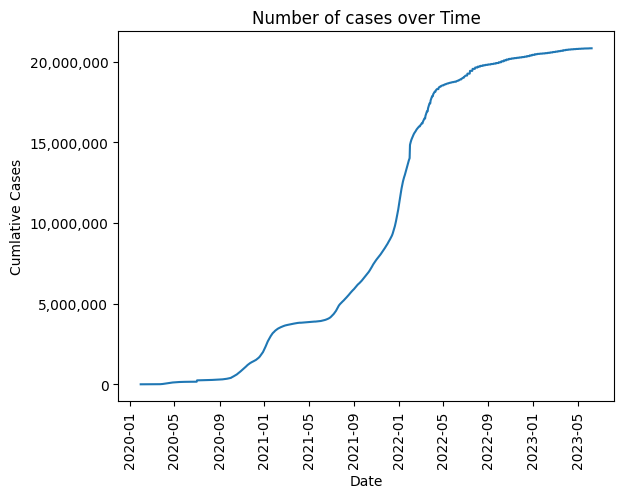

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tick

# line graph of cumlativeCases using seaborn
sns.lineplot(x='date', y='cumulativeCases', data=df)

# x/y labels and title
plt.xlabel('Date')
plt.ylabel('Cumlative Cases')
plt.title('Number of cases over Time')
plt.xticks(rotation='vertical')


# format to display y axis as 1,000,000 vs scientific notation e.g 
formatter = tick.FuncFormatter(lambda y, _: '{:,.0f}'.format(y))

# apply above to y-axis
plt.gca().yaxis.set_major_formatter(formatter)

# show graph
plt.show()

Perform seasonal decomposition analysis on the daily cases data

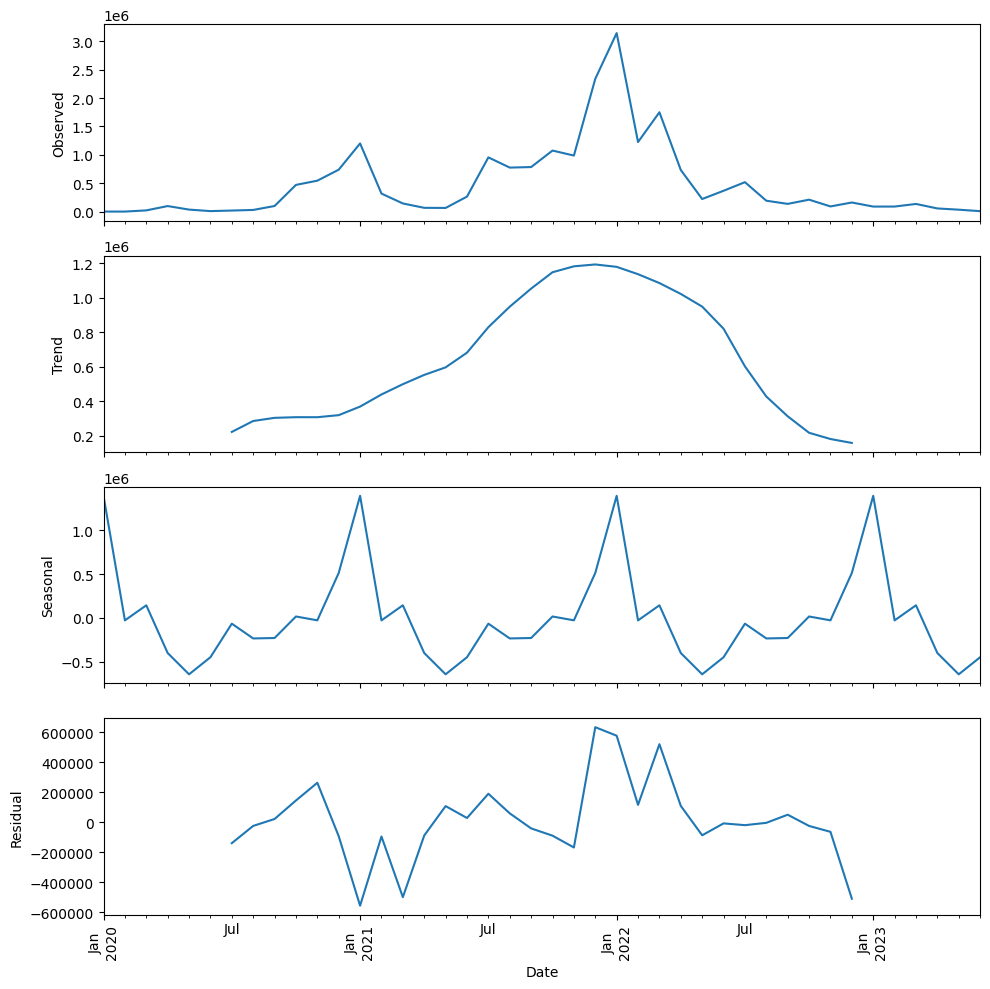

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns


# perform seasonal analysis 
result = seasonal_decompose(df_monthly['dailyCases'], model='additive', period=12)

# confgure the graph
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# plot graphs, had to do this way to plot vertical x axis tick labels
result.observed.plot(ax=axes[0])
axes[0].set_ylabel('Observed')
axes[0].set_xlabel('')

result.trend.plot(ax=axes[1])
axes[1].set_ylabel('Trend')
axes[1].set_xlabel('')

result.seasonal.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal')
axes[2].set_xlabel('')

result.resid.plot(ax=axes[3])
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

# now rotating x-axis tick labels vertically works
plt.xticks(rotation='vertical')

# make spacing between subplots nice
plt.tight_layout()

# display the plot
plt.show()
